While editing this notebook, don't change cell types as that confuses the autograder.

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [1]:
NAME = "Ishan Ranjan"

_Understanding Deep Learning_

---

<a href="https://colab.research.google.com/github/DL4DS/sp2024_notebooks/blob/main/release/nbs15/15_1_GAN_Toy_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 15.1: GAN Toy example

This notebook investigates the GAN toy example as illustrated in figure 15.1 in the book.

One difference from the example in the book is that we are not drawing a new random sample
on each GAN iteration.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Get a batch of real data.  Our goal is to make data that looks like this.
def get_real_data_batch(n_sample):
  np.random.seed(0)
  x_true = np.random.normal(size=(1,n_sample)) + 7.5
  return x_true

Define our generator.  This takes a standard normally-distributed latent variable $z$ and adds a scalar $\theta$ to this, where $\theta$ is the single parameter of this generative model according to:

\begin{equation}
x_i = z_i + \theta.
\end{equation}

Obviously this model can generate the family of Gaussian distributions with unit variance, but different means.

In [4]:
# This is our generator -- takes the single parameter theta
# of the generative model, adds it to each element of z, and
# returns the result.
def generator(z, theta):
    x_gen = z + theta
    return x_gen

Now, we define our discriminator.  This is a simple logistic regression model (1D linear model passed through sigmoid) that returns the probability that the data is real

In [5]:
# Define our discriminative model

# Logistic sigmoid, maps from [-infty,infty] to [0,1]
def sigmoid(data_in):
  return  1.0 / (1.0+np.exp(-data_in))

# Discriminator computes y
def discriminator(x, phi0, phi1):
  return sigmoid(phi0 + phi1 * x)

In [6]:
# Draws a figure like Figure 15.1a
def draw_data_model(x_real, x_syn, phi0=None, phi1=None):
  fix, ax = plt.subplots();

  for x in x_syn:
    ax.plot([x,x],[0,0.33],color='#f47a60')
  for x in x_real:
    ax.plot([x,x],[0,0.33],color='#7fe7dc')

  if phi0 is not None:
    x_model = np.arange(0,10,0.01)
    y_model = discriminator(x_model, phi0, phi1)
    ax.plot(x_model, y_model,color='#dddddd')
  ax.set_xlim([0,10])
  ax.set_ylim([0,1])


  plt.show()

Generated and real samples along with untrained discriminator plot.


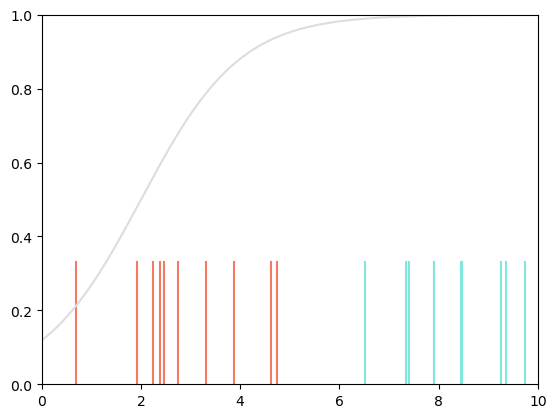

In [7]:
# Get data batch
x_real = get_real_data_batch(10)

# Initialize generator and synthesize a batch of examples
theta = 3.0
np.random.seed(1)
z = np.random.normal(size=(1,10))
x_syn = generator(z, theta)

# Initialize discriminator model
phi0 = -2
phi1 = 1

print("Generated and real samples along with untrained discriminator plot.")
draw_data_model(x_real, x_syn, phi0, phi1)

You can see that the synthesized (orange) samples don't look much like the real (cyan) ones, and the initial model to discriminate them (gray line represents probability of being real) is pretty bad as well.

Let's deal with the discriminator first.  Let's define the loss

In [8]:
# Discriminator loss
def compute_discriminator_loss(x_real, x_syn, phi0, phi1):

  # TODO -- compute the loss for the discriminator
  # Run the real data and the synthetic data through the discriminator
  # Then use the standard binary cross entropy loss with the y=1 for the real samples
  # and y=0 for the synthesized ones.
  #
  # See Section 15.1.1 and 15.1.2
  
  # YOUR CODE HERE
  # Compute the discriminator loss
  y_real = discriminator(x_real, phi0, phi1)
  y_syn = discriminator(x_syn, phi0, phi1)
  loss = -np.log(y_real).sum() - np.log(1-y_syn).sum()

  return loss

In [9]:
# Test the loss
loss = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
print("True Loss = 13.814757170851447, Your loss=", loss )

assert np.abs(loss - 13.814757170851447) < 1e-5, "Loss is incorrect"

True Loss = 13.814757170851447, Your loss= 13.814757170851445


In [10]:
def compute_discriminator_gradient(x_real, x_syn, phi0, phi1):
  """
  Approximate the gradient of the discriminator loss with respect to phi0 and phi1 using finite differences.
  """
  delta = 0.0001;
  loss1 = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
  loss2 = compute_discriminator_loss(x_real, x_syn, phi0+delta, phi1)
  loss3 = compute_discriminator_loss(x_real, x_syn, phi0, phi1+delta)
  dl_dphi0 = (loss2-loss1) / delta
  dl_dphi1 = (loss3-loss1) / delta

  return dl_dphi0, dl_dphi1

def update_discriminator(x_real, x_syn, n_iter, phi0, phi1):
  """
  Perform n_iter steps of gradient descent on the discriminator loss function
  with a fixed, hardcoded learning rate.
  """

  # Define learning rate
  alpha = 0.01

  # Get derivatives
  print("Initial discriminator loss = ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))
  for iter in range(n_iter):
    # Get gradient
    dl_dphi0, dl_dphi1 = compute_discriminator_gradient(x_real, x_syn, phi0, phi1)
    # Take a gradient step downhill
    phi0 = phi0 - alpha * dl_dphi0 ;
    phi1 = phi1 - alpha * dl_dphi1 ;

  print("Final Discriminator Loss= ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))

  return phi0, phi1

Initial parameters (phi0,phi1) -2 1
Initial discriminator loss =  13.814757170851445
Final Discriminator Loss=  3.732902478030793
Final parameters (phi0,phi1) -3.5540834577190132 0.714329052357753


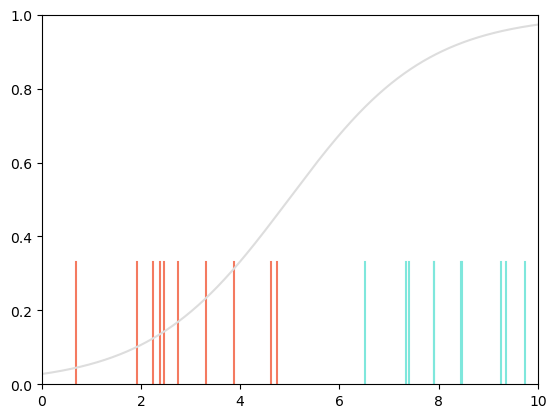

In [11]:
# Let's update the discriminator (sigmoid curve)
n_iter = 100
print("Initial parameters (phi0,phi1)", phi0, phi1)

phi0, phi1 = update_discriminator(x_real, x_syn, n_iter, phi0, phi1)

print("Final parameters (phi0,phi1)", phi0, phi1)

draw_data_model(x_real, x_syn, phi0, phi1)

Now let's update the generator

In [33]:
def compute_generator_loss(z, theta, phi0, phi1):
  # TODO:
  # 1. Run the generator on the latent variables z with the parameters theta
  #    to generate new data x_syn
  # 2. Then run the discriminator on the new data to get the probability of being real
  # 3. The loss is the total negative log probability of being synthesized (i.e. of not being real)
  
  # YOUR CODE HERE
  x_syn = generator(z, theta)
  y_syn = discriminator(x_syn, phi0, phi1)
  loss = -np.log(1-y_syn).sum()
  return loss

In [34]:
# Test generator loss to check you have it correct
loss = compute_generator_loss(z, theta, -2, 1)
print("True Loss = 13.78437035945412, Your loss=", loss )

assert np.abs(loss - 13.78437035945412) < 1e-5, "Loss is incorrect"

True Loss = 13.78437035945412, Your loss= 13.784370359454119


In [35]:
def compute_generator_gradient(z, theta, phi0, phi1):
  """
  Approximate the gradient of the generator loss with respect to theta using finite differences.
  """
  delta = 0.0001
  loss1 = compute_generator_loss(z,theta, phi0, phi1) ;
  loss2 = compute_generator_loss(z,theta+delta, phi0, phi1) ;
  dl_dtheta = (loss2-loss1)/ delta
  return dl_dtheta

def update_generator(z, theta, n_iter, phi0, phi1):
    """
    Perform n_iter steps of gradient _ascent_ on the generator loss function
    """
    # Define learning rate
    alpha = 0.02

    # Get derivatives
    print("Initial generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    for iter in range(n_iter):
      # Get gradient
      dl_dtheta = compute_generator_gradient(x_real, x_syn, phi0, phi1)
      
      # Take a gradient step (uphill, since we are trying to make synthesized data less well classified by discriminator)
      theta = theta + alpha * dl_dtheta ;

    print("Final generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    return theta


Theta before 3.0
Initial generator loss =  2.6027212360722745
Final generator loss =  5.591742642830356
Theta after 4.387548766203395


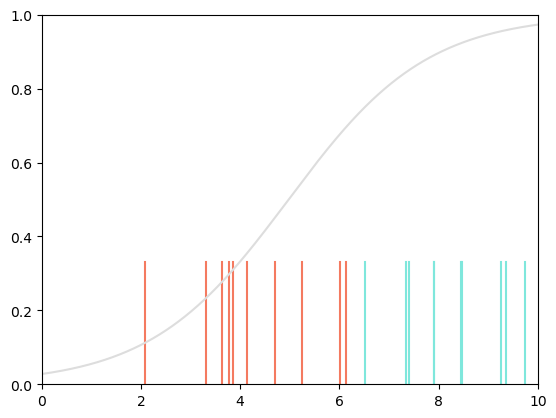

In [36]:
n_iter = 10
theta = 3.0
print("Theta before", theta)
theta = update_generator(z, theta, n_iter, phi0, phi1)
print("Theta after", theta)

x_syn = generator(z,theta)
draw_data_model(x_real, x_syn, phi0, phi1)

Initial parameters (phi0,phi1) of the discriminator -2 1
GAN iteration 0
Synthesized data


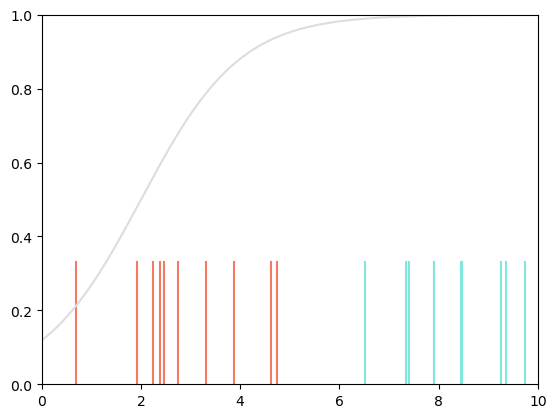

Updating discriminator
Initial discriminator loss =  13.814757170851445
Final Discriminator Loss=  2.318847463522897


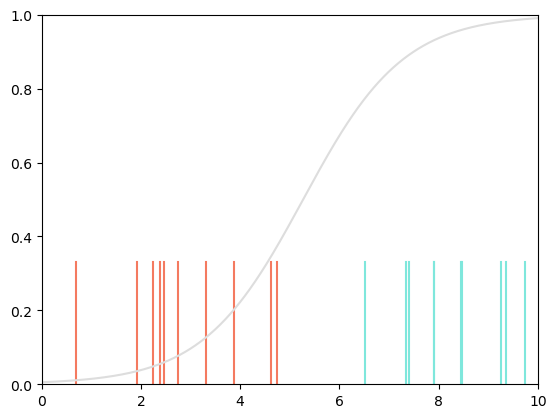

Updating generator
Initial generator loss =  1.5508571592281153
Final generator loss =  2.498619627822334
GAN iteration 1
Synthesized data


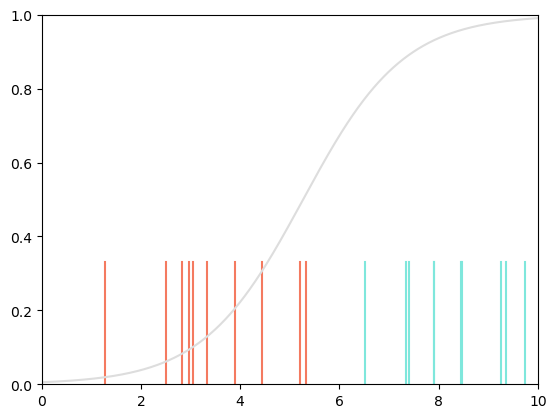

Updating discriminator
Initial discriminator loss =  3.2666099321171154
Final Discriminator Loss=  2.258726003237274


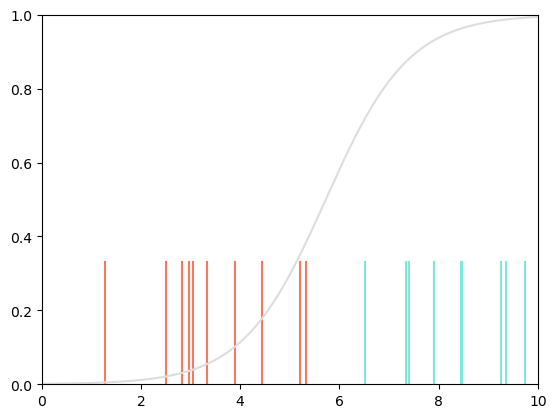

Updating generator
Initial generator loss =  1.4134209574731904
Final generator loss =  2.7862808898166516
GAN iteration 2
Synthesized data


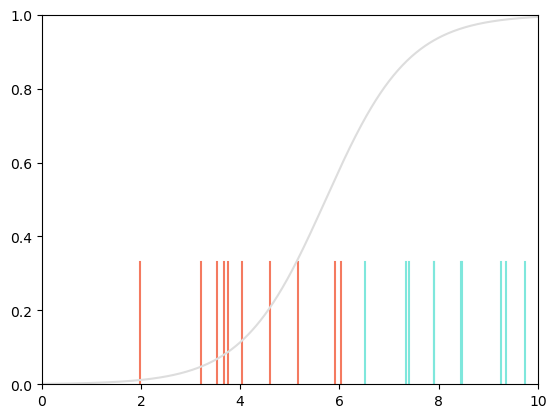

Updating discriminator
Initial discriminator loss =  3.631585935580735
Final Discriminator Loss=  2.906023814087535


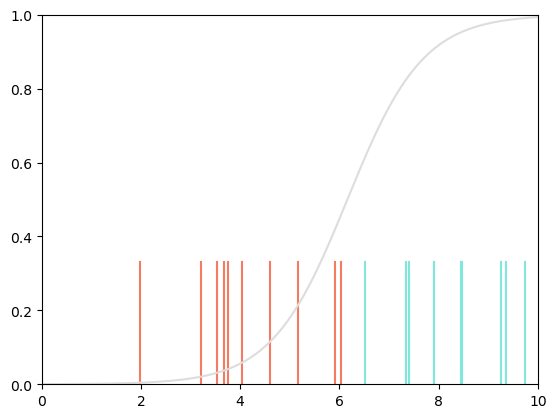

Updating generator
Initial generator loss =  1.7177761014705686
Final generator loss =  3.710564577006054
GAN iteration 3
Synthesized data


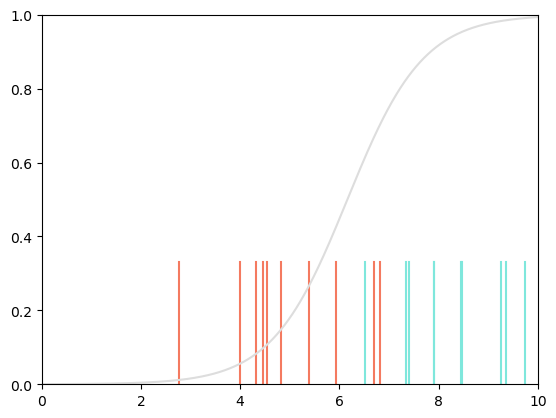

Updating discriminator
Initial discriminator loss =  4.89881228962302
Final Discriminator Loss=  4.261135861106877


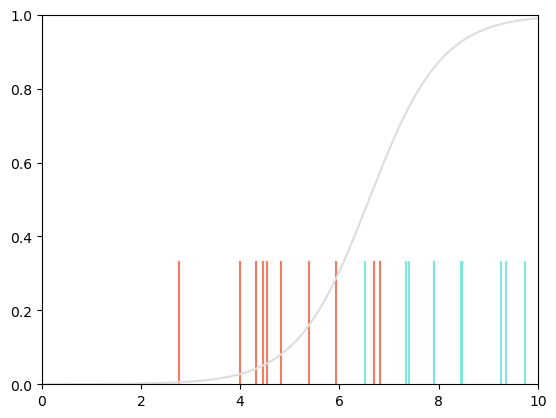

Updating generator
Initial generator loss =  2.4001461120734495
Final generator loss =  5.190633298661235
GAN iteration 4
Synthesized data


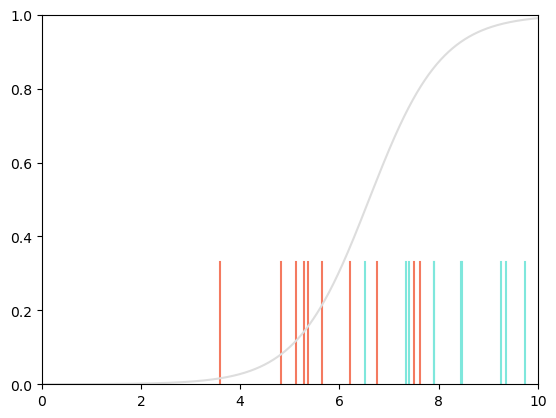

Updating discriminator
Initial discriminator loss =  7.051623047694663
Final Discriminator Loss=  6.493000484941712


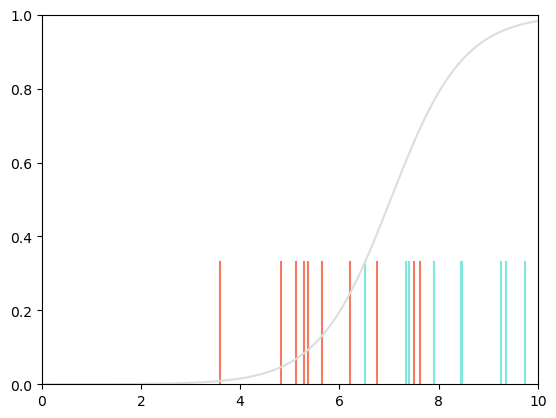

Updating generator
Initial generator loss =  3.5153009148679915
Final generator loss =  7.093197687345657
Final parameters (phi0,phi1) -9.611812768231774 1.3669796442013151


In [37]:
# Now let's define a full GAN loop

# Initialize the parameters
theta = 3
phi0 = -2
phi1 = 1

np.random.seed(1)
z = np.random.normal(size=(1,10))

# Number of iterations for updating generator and discriminator
n_iter_discrim = 300
n_iter_gen = 3

print("Initial parameters (phi0,phi1) of the discriminator", phi0, phi1)
for c_gan_iter in range(5):  # originally 5. Feel free to experiment with more iterations

  print("====================================")
  print("GAN iteration", c_gan_iter)
  print("====================================")

  # Run generator to produce synthesized data
  x_syn = generator(z, theta)

  print("Synthesized data")
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the discriminator
  print("Updating discriminator")
  phi0, phi1 = update_discriminator(x_real, x_syn, n_iter_discrim, phi0, phi1)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the generator
  print("Updating generator")
  theta = update_generator(z, theta, n_iter_gen, phi0, phi1)

print("Final parameters (phi0,phi1)", phi0, phi1)


You can see that the synthesized data (orange) is becoming closer to the true data (cyan).  However, this is extremely unstable -- as you will find if you mess around with the number of iterations of each optimization and the total iterations overall.